# STM32Cube.AI Developer Cloud Notebook


This notebook shows how to access to the STM32Cube.AI Developer Cloud through ST Python APIs (based on REST API) instead of using the web application  https://stm32ai-cs.st.com.

It allows a seamless integration in your MLOps flow without the need to install STM32Cube.AI, through a simple Python interface.

User can either upload its own model or select one of the models from STM32 model zoo accessible also through github: https://github.com/STMicroelectronics/stm32ai-modelzoo

Then thanks to the STM32Cube.AI Developer Cloud, the model can be analyzed and benchmarked on a broad range of STM32 boards.

And finaly the optimized C-code corresponding to the model can be downloaded to be integrated in the final application.

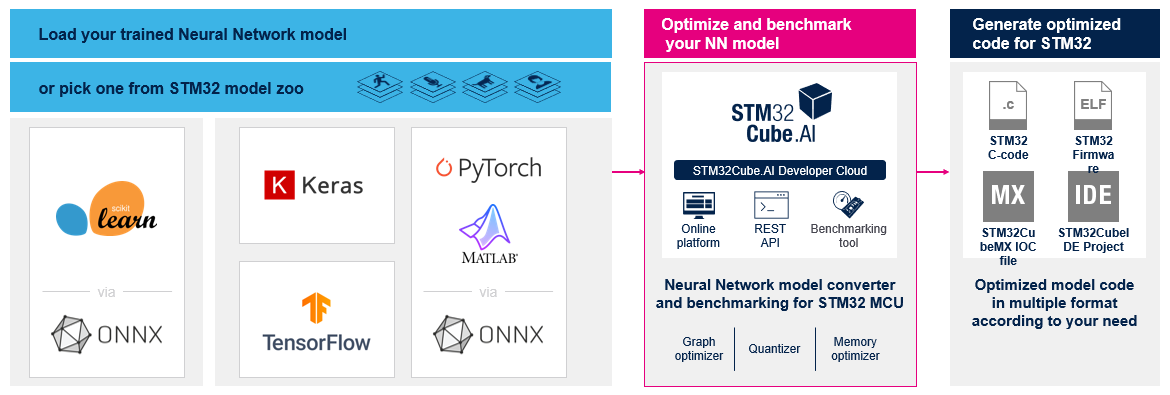


## License of the Jupyter Notebook
This software component is licensed by ST under BSD-3-Clause license.


"License";

You may not use this file except in compliance with the License.

You may obtain a copy of the License at: https://opensource.org/licenses/BSD-3-Clause

Copyright (c) 2023 STMicroelectronics. All rights reserved.

## Proxy setting

If you are behind a proxy, you can uncomment and fill the following proxy setting.

**NOTE**: If the password contains some special characters like `@`, `:` etc. they need to be url-encoded.

In [ ]:
import os
# os.environ['http_proxy'] = "http://user:passwd@ip_address:port"
# os.environ['https_proxy'] = "https://user:passwd@ip_address:port"
# And eventually disable SSL verification
# os.environ['NO_SSL_VERIFY'] = 1

## Install packages

In [ ]:
import sys
!{sys.executable} -m pip install pycurl seaborn numpy matplotlib
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install gitdir
!{sys.executable} -m pip install shutils
!{sys.executable} -m pip install marshmallow

## Download the STM32Cube.AI Developer Cloud Python API package

This Python package allows you to access to the STM32Cube.AI Developer Cloud through REST API.

In [ ]:
import os
import shutil
# Get STM32Cube.AI Developer Cloud
!gitdir https://github.com/STMicroelectronics/stm32ai-modelzoo/tree/main/common/stm32ai_dc

# Reorganize local folders
if os.path.exists('./stm32ai_dc'):
    shutil.rmtree('./stm32ai_dc')
shutil.move('./common/stm32ai_dc', './stm32ai_dc')
shutil.rmtree('./common')

## Import, helper and UI functions

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from stm32ai_dc import (CliLibraryIde, CliLibrarySerie, CliParameters, MpuParameters, MpuEngine,
                        CloudBackend, Stm32Ai)

sys.path.append(os.path.abspath('stm32ai'))
os.environ['STATS_TYPE'] = 'jupyter_devcloud'

os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)


def get_mpu_options(board_name: str = None) -> tuple:
    """
    Get MPU benchmark options depending on MPU board selected
    Each MPU board has different settings,
    i.e. different number of cpu_cores or engine (CPU only or HW_Accelerator also)
    Input:
        board_name:str, name of the mpu board
    Returns:
        tuple: engine_used and num_cpu_cores.
    """

    #define configuration by MPU board
    STM32MP257F_EV1 = {
        "engine": MpuEngine.HW_ACCELERATOR,
        "cpu_cores": 2
    }

    STM32MP157F_DK2 = {
        "engine": MpuEngine.CPU,
        "cpu_cores": 2
    }

    STM32MP135F_DK = {
        "engine": MpuEngine.CPU,
        "cpu_cores": 1
    }

    #recover parameters based on board name:
    if board_name == "STM32MP257F-EV1":
        engine_used = STM32MP257F_EV1.get("engine")
        num_cpu_cores = STM32MP257F_EV1.get("cpu_cores")
    elif board_name == "STM32MP157F-DK2":
        engine_used = STM32MP157F_DK2.get("engine")
        num_cpu_cores = STM32MP157F_DK2.get("cpu_cores")
    elif board_name == "STM32MP135F-DK":
        engine_used = STM32MP135F_DK.get("engine")
        num_cpu_cores = STM32MP135F_DK.get("cpu_cores")
    else :
        engine_used = MpuEngine.CPU
        num_cpu_cores = 1

    return engine_used, num_cpu_cores

def analyze_footprints(report: object = None) -> None:
    """
    Analyzes the memory footprint of a STM32Cube.AI model.

    Args:
        report: A report object containing information about the model.

    Returns:
        None
    """
    activations_ram: float = report.ram_size / 1024
    runtime_ram: float = report.estimated_library_ram_size / 1024
    total_ram: float = activations_ram + runtime_ram
    weights_rom: float = report.rom_size / 1024
    code_rom: float = report.estimated_library_flash_size / 1024
    total_flash: float = weights_rom + code_rom
    macc: float = report.macc / 1e6
    print("[INFO] : STM32Cube.AI model memory footprint")
    print("[INFO] : MACCs : {} (M)".format(macc))
    print("[INFO] : Total Flash : {0:.1f} (KiB)".format(total_flash))
    print("[INFO] :     Flash Weights  : {0:.1f} (KiB)".format(weights_rom))
    print("[INFO] :     Estimated Flash Code : {0:.1f} (KiB)".format(code_rom))
    print("[INFO] : Total RAM : {0:.1f} (KiB)".format(total_ram))
    print("[INFO] :     RAM Activations : {0:.1f} (KiB)".format(activations_ram))
    print("[INFO] :     RAM Runtime : {0:.1f} (KiB)".format(runtime_ram))


def benchmark_model(stmai:object,
                    model_path:str,
                    model_name:str,
                    optimization:str,
                    from_model:str,
                    board_name:str,
                    allocateInputs:bool =True,
                    allocateOutputs:bool=True,
                    noOnnxIoTranspose:bool=True) -> float:
    """
    Benchmarks the give model to calculate the footprint on a STM32 Target board.

    Args:
        stmai:object, an object of stm32ai_dc
        model_path:str, path to the model file
        model_name:str, path to the model file
        optimization:str, the way model is to be optimized available options ['balanced', 'time', 'ram']
        from_model:str, if the model is coming from zoo or is a custom model from the user
        board_name:str, target board name from one of the available boards on the dev cloud
        allocateInputs:bool, If set to true activations buffer will be also used to handle the input buffers. 
        allocateOutputs:bool, If set to "True", activations buffer will be also used to handle the output buffers
        noOnnxIoTranspose:bool, If set to "True", this flag should be used to avoid adding a specific transpose layer during the import of an ONNX model.

    Returns:
        fps: frames per second (1/inference_time)
    """
    print(f"Benchmarking on: {board_name}")
    if "mp" in board_name.lower():
        # if mpu is selected as the target
        model_extension = os.path.splitext(model_path)[1]
        # only supported options are quantized tflite or onnx models
        if model_extension in ['.onnx', '.tflite']:
            if "stm32mp2" in board_name.lower(): # if mp2 is selected as the target board optimize the model to generate a .nbg file
                optimized_model_path = os.path.dirname(model_path) + "/"
                try:
                    stmai.upload_model(model_path)
                    model = model_name
                    res = stmai.generate_nbg(model)
                    stmai.download_model(res, optimized_model_path + res)
                    model_path=os.path.join(optimized_model_path,res)
                    nb_model_name = os.path.splitext(os.path.basename(model_path))[0] + ".nb"
                    rename_model_path=os.path.join(optimized_model_path,nb_model_name)
                    os.rename(model_path, rename_model_path)
                    model_path = rename_model_path
                    print("[INFO] : Optimized Model Name:", model_name)
                    print("[INFO] : Optimization done ! Model available at :",optimized_model_path)
                    model_name = nb_model_name
                except Exception as e:
                    print(f"[FAIL] : Model optimization via Cloud failed : {e}.")
                    print("[INFO] : Use default model instead of optimized ...")
        else:
            print("[ERROR]: Only .tflite or .onnx models can be benchmarked for MPU")
            fps = 0
            return fps

        engine, nbCores = get_mpu_options(board_name)
        stmai_params = MpuParameters(model=model_name,
                                     nbCores=nbCores,
                                     engine=engine)

    else:
        # target board in mcu, prepare stm32ai parameters
        stmai_params = CliParameters(model=model_name,
                                     optimization=optimization,
                                     allocateInputs=allocateInputs,
                                     allocateOutputs=allocateOutputs,
                                     noOnnxIoTranspose=noOnnxIoTranspose,
                                     fromModel=from_model)
    # running the benchmarking with prepared params
    try:
        result = stmai.benchmark(stmai_params, board_name)
        fps = analyze_inference_time(report=result,
                                     target_mpu="mp" in board_name.lower())

        # Save the result in outputs folder
        with open(f'./outputs/{model_name}_{board_name}.txt', 'w') as file_benchmark:
            file_benchmark.write(f'{result}')
        return fps

    except Exception as e:
        print(f"Benchmarking failed on board: {board_name}")
        fps = 0
        return fps

def analyze_inference_time(report: object = None,
                           target_mpu = False) -> float:
    """
    Analyzes the inference time of a STM32Cube.AI model, prints the report and return the FPS.
    Args:
        report: A report object containing information about the model.
        target_mpu: a boolean (True: if target is MPU, False: otherwise)

    Returns:
        The frames per second (FPS) of the model.
    """

    inference_time: float = report.duration_ms
    fps: float = 1000.0/inference_time
    if not target_mpu:
        # in mpu benchmark result report we do not have cycles
        cycles: int = report.cycles
        print("[INFO] : Number of cycles : {} ".format(cycles))
    print("[INFO] : Inference Time : {0:.1f} (ms)".format(inference_time))
    print("[INFO] : FPS : {0:.1f}".format(fps))
    return fps


# UI widgets

# optimization options
optimization: list[str] = ['balanced', 'time', 'ram']
optim_dropdown: widgets.Dropdown = widgets.Dropdown(
    options=optimization,
    value=optimization[0],
    description='Optim:',
    disabled=False
)

# STM32MCU series for code generation target
series_name: list[str] = [
    "STM32H7", "STM32F7", "STM32F4", "STM32L4", "STM32G4",
    "STM32F3", "STM32U5", "STM32L5", "STM32F0", "STM32L0",
    "STM32G0", "STM32C0", "STM32WL", "STM32H5"
]
series_dropdown: widgets.Dropdown = widgets.Dropdown(
    options=series_name,
    value=series_name[0],
    description='Series:',
    disabled=False
)

# options for the IDE while code generation
IDE_name: list[str] = ["gcc", "iar", "keil"]
ide_dropdown: widgets.Dropdown = widgets.Dropdown(
    options=IDE_name,
    value=IDE_name[0],
    description='IDE:',
    disabled=False
)

# options for the available versions of STM32Cube.AI to be used
stm32ai_versions: list[str] = ["8.1.0", "9.0.0", "9.1.0"]
stm32ai_version_dropdown: widgets.Dropdown = widgets.Dropdown(
    options=stm32ai_versions,
    value=stm32ai_versions[-1],
    description='STM32AI version:',
    disabled=False
)

## Login to STM32Cube.AI Developer Cloud
Set environment variables with your credentials to access STM32Cube.AI Developer Cloud.

If you don't have an account yet go to: https://stm32ai-cs.st.com/home and click on sign in to create an account.

Then set the environment variables below with your credentials.


In [ ]:
import getpass
import os

# Set environment variables with your credentials to access
# STM32Cube.AI Developer Cloud services
# Fill the username with your login address
username = 'xxx@yyy.com'
os.environ['stmai_username'] = username

print('Enter your password')
password = getpass.getpass()
os.environ['stmai_password'] = password

Select the version of STM32Cube.AI to be used!

In [ ]:
display(stm32ai_version_dropdown)

In [ ]:
# Log in STM32Cube.AI Developer Cloud
try:
    stmai = Stm32Ai(CloudBackend(str(username), str(password), str(stm32ai_version_dropdown.value)))
    print(f"Successfully Connected!")
except Exception as e:
    print("Error: please verify your credentials")

## Select a pre-trained model

### Optional: download models from STM32 model zoo

Select from an extract of models available on STM32 model zoo and download it.


In [ ]:
import json

!curl -o models_list.json https://stm32ai-cs.st.com/api/file/zoo/models

with open('models_list.json') as model_file:
  st_models = json.loads(model_file.read())

model_server_paths = [d['server_path'] for d in st_models]
model_server_readme = [d['readme'] for d in st_models]
model_zoo_list = [s.split('/')[1] for s in model_server_paths]
model_zoo_display = [(string, index + 1) for index, string in enumerate(model_zoo_list)]

modelzoo_dropdown = widgets.Dropdown(
    options=model_zoo_display,
    value=1,
    description='Models: ')

print('\nSTM32 model zoo')
display(modelzoo_dropdown)

In [ ]:
model_name = model_zoo_list[modelzoo_dropdown.value-1]
print(f'{model_name} details:\n',model_server_readme[modelzoo_dropdown.value-1])

In [ ]:
# Dowload the selected model
model_server_path = model_server_paths[modelzoo_dropdown.value-1]
model_link = f'https://stm32ai-cs.st.com/api/file/zoo/models/{model_server_path}'
# stmai.download_model(model_server_path)
model_path = f'./models/{model_name}'
!curl -o $model_path $model_link
print(os.listdir('./models'))

## Select a model from the models directory

You can upload your own model in the models folder.
Then select a model among the models stored in the "models" folder.

In [ ]:
# Get the models available locally
model_list = []
for entry in os.listdir('./models'):
  if os.path.isfile(os.path.join('./models', entry)):
    model_list.append(entry)
model_sel_dropdown = widgets.Dropdown(
    options=model_list,
    value=model_list[0],
    description='Model:',
    disabled=False
)
display(model_sel_dropdown)

## Upload the model on STM32Cube.AI Developer Cloud

In [ ]:
model_name = model_sel_dropdown.value
model_path = f'./models/{model_name}'
from_model = 'user'
for name in model_zoo_list:
    if model_name == name:
        from_model = model_name
        break
try:
  stmai.upload_model(model_path)
  print(f'Model {model_name} is uploaded !')
except Exception as e:
    print("ERROR: ", e)

## Select the STM32Cube.AI optimization setting

| Configuration | Description |
| --- | --- |
| balanced | default compromise between RAM footprint and latency. |
| time | optimize for latency. |
| ram | optimize for minimal RAM footprint. |

In [ ]:
display(optim_dropdown)

## Analyze your model memory footprints for STM32MCU targets
When analyzing the footprints of the model for STM32MCU targets, following parameters can be configured for stm32ai.analyze callback:

CLIParameters (options of STM32Cube.AI):

| Parameter | Description |
| --- | --- |
| model | Model name corresponding to the file name uploaded. This parameter is __required__. |
| optimization | Optimization setting: "balanced", "time" or "ram". This parameter is __required__. |
| allocateInputs | If set to "True", activations buffer will be also used to handle the input buffers. This parameter is __optional__. Default value is "True". |
| allocateOutputs | If set to "True", activations buffer will be also used to handle the output buffers. This parameter is __optional__. Default value is "True". |
| noOnnxOptimizer | If set to "True", allows to disable the ONNX optimizer pass. This parameter is __optional__. Default value is "False". |
| noOnnxIoTranspose | If set to "True", this flag should be used to avoid adding a specific transpose layer during the import of an ONNX model. This parameter is __optional__. Default value is "False". |
| fromModel | To identify the origin model when coming from ST model zoo. This parameter is __optional__. Default value is "user".|

In [ ]:
# Analyze RAM/Flash model memory footprints after optimization by STM32Cube.AI
optimization = optim_dropdown.value
print(f'{model_name} optimization {optimization}')

# The runtime library footprint varies slightly depending on the STM32 series
# For an estimation, we use the default series to the STM32F4
try:
    result = stmai.analyze(CliParameters(model=model_path,
                                         optimization=optimization,
                                         allocateInputs=True,
                                         allocateOutputs=True,
                                         noOnnxIoTranspose=True,
                                         fromModel=from_model))

    # analyze and print the summary of footprint report
    analyze_footprints(report=result)

    # Save the result in outputs folder
    with open(f'./outputs/{model_name}_analyze.txt', 'w') as file_analyze:
        file_analyze.write(f'{result}')

except Exception as e:
    print("Error: ", e)

## Benchmark your model on a STM32 target

Starting from STM32Cube.AI dev cloud version 9.0.0 onwards, the models can be benchmarked for STM32MCU as well as for STM32MPU target boards.

Here's a table with the parameters and their descriptions while benchmarking for the STM32MCU targets (CLIParameters options of STM32Cube.AI):

| Parameter | Description |
| --- | --- |
| model | Model name corresponding to the file name uploaded. This parameter is required. |
| optimization | Optimization setting: "balanced", "time" or "ram". This parameter is required. |
| allocateInputs | If set to "True", activations buffer will be also used to handle the input buffers. This parameter is optional. Default value is "True". |
| allocateOutputs | If set to "True", activations buffer will be also used to handle the output buffers. This parameter is optional. Default value is "True". |
| noOnnxOptimizer | If set to "True", allows to disable the ONNX optimizer pass. This parameter is optional. Default value is "False". Apply only to ONNX file will be ignored otherwise. |
| noOnnxIoTranspose | If set to "True", this flag should be used to avoid adding a specific transpose layer during the import of an ONNX model. This parameter is optional. Default value is "False". Apply only to ONNX file will be ignored otherwise. |
| fromModel | To identify the origin model when coming from ST model zoo. This parameter is optional. Default value is "user". |


While for the STM32MPU targets, only needed parameters are:

| Parameter | Description |
| --- | --- |
| model | Model name corresponding to the file name uploaded. This parameter is __required__. |
| nbCores | Number of CPU cores used for benchmarking. This parameter is __set by the code__ depending on the type of MPU. The value should be an integer "1", or "2". |
| engine | Choice of the hardware engine used on the board for benchmarking.This parameter is __set by the code__ depending on the target MPU. For STM32MP1X boards it is "MpuEngine.CPU" and for STM32MP2X this is "MpuEngine.HW_ACCELERATOR". |

* Note that the the code section below, the boad_name to benchmark the model on should be a string

In [ ]:
# Get the available board on STM32Cube.AI Developer Cloud
boards = stmai.get_benchmark_boards()
board_names = [boards[i].name for i in range(len(boards))]
print("Available boards:", board_names)

## Option 1: Benchmark on all available STM32 boards

In [ ]:
# Benchmark the model on all STM32Cube.AI Developer Cloud boards
print(model_name)
fps_array = []
# loop through all boards
for board_name in board_names:
        fps_array.append(benchmark_model(stmai=stmai,
                                         model_path=model_path,
                                         model_name=model_name,
                                         optimization=optimization,
                                         from_model=from_model,
                                         board_name=board_name,
                                         allocateInputs= True,
                                         allocateOutputs=True,
                                         noOnnxIoTranspose=True))

In [ ]:
plt.xticks(rotation=45, ha='right')
plt.xlabel('Board Name', fontsize=15)

# Display the Frame per Second benchmark
sorted_fps = sorted(fps_array, reverse=True)
sorted_boards = [board_names[fps_array.index(i)] for i in sorted_fps]

fig = plt.figure(1, figsize=(15, 6), tight_layout=True)
colors = sns.color_palette()

plt.bar(sorted_boards, sorted_fps, color=colors[:len(boards)], width=0.7)
plt.ylabel('FPS', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Board Name', fontsize=15)
plt.title('STM32 FPS benchmark')
plt.show()

## Option 2: Benchmark on a selected board

In [ ]:
# Select a board among the available boards
board_dropdown = widgets.Dropdown(
    options = board_names,
    value = board_names[0],
    description ='Board:',
    disabled = False,)

display(board_dropdown)

In [ ]:
board_name = board_dropdown.value
print(model_name, board_name)
fps = benchmark_model(stmai=stmai,
                      model_path=model_path,
                      model_name=model_name,
                      optimization=optimization,
                      from_model=from_model,
                      board_name=board_name,
                      allocateInputs= True,
                      allocateOutputs=True,
                      noOnnxIoTranspose=True)

## Generate your model optimized C code for STM32MCU targets

To deploy the model on an STM32MCU target the user has to generate the C-Code of the optimized model. Here's a table with the parameters and their descriptions for the stm32.generate callback (CLIParameters of STM32Cube.AI):

| Parameter | Description |
| --- | --- |
| model | Model name corresponding to the file name uploaded. This parameter is required. |
| optimization | Optimization setting: "balanced", "time" or "ram". This parameter is required. |
| allocateInputs | If set to "True", activations buffer will be also used to handle the input buffers. This parameter is optional. Default value is "True". |
| allocateOutputs | If set to "True", activations buffer will be also used to handle the output buffers. This parameter is optional. Default value is "True". |
| noOnnxOptimizer | If set to "True", allows to disable the ONNX optimizer pass. This parameter is optional. Default value is "False". Apply only to ONNX file will be ignored otherwise. |
| noOnnxIoTranspose | If set to "True", this flag should be used to avoid adding a specific transpose layer during the import of an ONNX model. This parameter is optional. Default value is "False". Apply only to ONNX file will be ignored otherwise. |
| includeLibraryForSerie | Include the runtime library for the given STM32 series. This parameter is optional. |
| fromModel | To identify the origin model when coming from ST model zoo. This parameter is optional. |



### NOTE

There is no need for this step if the deployment is intended on the MPU. One can directly deploy the .tflite model on the STM32MPUs. In case of STM32MP2x, an optimized version of the model should be already available in the path where the starting model was placed with the same name as model and extension ".nb".

In [ ]:
display(series_dropdown)
display(ide_dropdown)

In [ ]:
series = series_dropdown.value
IDE = ide_dropdown.value

print(f'{model_name}\ngenerating code for {series}')

os.makedirs('./code_outputs', exist_ok=True)

# Generate model .c/.h code + Lib/Inc on STM32Cube.AI Developer Cloud
result = stmai.generate(CliParameters(
    model=model_name,
    output="./code_outputs",
    optimization=optimization,
    allocateInputs=True,
    allocateOutputs=True,
    noOnnxIoTranspose=True,
    includeLibraryForSerie=CliLibrarySerie(series),
    includeLibraryForIde=CliLibraryIde(IDE),
    fromModel=from_model
))

print(os.listdir("./code_outputs"))

# print 20 first lines of the report
with open('./code_outputs/network_generate_report.txt', 'r') as f:
    for _ in range(20):
        print(next(f))

## You are ready to integrate your model in your STM32 application !

### Delete your model from your STM32Cube.AI Developer Cloud space

In [ ]:
stmai.delete_model(model_name)

## If running on Colab zip and download the generated package

In [ ]:
import shutil
shutil.make_archive('code_outputs', 'zip', 'code_outputs')

In [ ]:
# If running on Colab, run this cell to automatically download the outputs.zip file, else download manually.
from google.colab import files
files.download('code_outputs.zip')

In [ ]:
!rm -r stm32ai_dc